In [407]:
import sklearn.datasets
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plot
from sklearn.tree import DecisionTreeRegressor

## Класс решающего дерева

In [408]:
# Используемые интерфейсы

# Класс предоставляющий стратегию получения потенциальных точек для разбиения
class UniformSplitter:
    def generate_ticks(self, x):
        k = int(len(x))
        return np.linspace(x.min(), x.max(), k)
    
# Класс предоставляющий меру "неоднородности" множества
class MseMeasure:
    def compute_measure(self, X, y):
        if (len(y) > 0):
            return y.var()
        else:
            return 0;
        
# Класс предоставляющий стратегию выбора ответа на подмножестве
class AverageValueDecision:
    def make_decision(self, X, y):
        return y.mean()

In [409]:
# Класс условия разбиения
class Condition:
    def __init__(self, feature, value):
        self.feature = feature
        self.value = value
        
    def __str__(self):
        return '{' + str(self.feature) + '} < ' + str(self.value)
    
    # Применяет свое условие к объекту с признаками x
    def apply_(self, x):
        return x[self.feature] < self.value
        
    # Распределяет объекты из X вместе с их метками y согласно своему условию
    def split(self, X, y):
        # объекты попадающие в истинное поддерево
        L = X[X[:, self.feature] < self.value]
        y_l = y[X[:, self.feature] < self.value]
        # объекты попадающие в ложную ветку
        R = X[X[:, self.feature] >= self.value]
        y_r = y[X[:, self.feature] >= self.value]
        return ((L, y_l), (R, y_r))

    
# Основной класс для дерева условий, узел дерева
class Node:
    def __init__(self, condition, decision):
        self.condition = condition
        self.decision = decision
        self.true = None
        self.false = None
    
    # Пройти по дереву, применяя по пути условия из узлов с целью получить в листе решение
    def trace(self, x):
        # Если лист, то пора принимать решение
        if self.condition == None:
            return self.decision
        
        if self.condition.apply_(x):
            if self.true != None:
                return self.true.trace(x)
            else:
                return self.decision
        else:
            if self.false != None:
                return self.false.trace(x)
            else:
                return self.decision
           
    # Пишет себя в строку с отступом. Необходимо для красивой печати дерева.
    def to_str_offset(self, offset=''):
        s = offset + str(self.condition) + '\n'
        if self.true != None:
            s += self.true.to_str_offset(offset + '\t') + '\n'
        if self.false != None:
            s += self.false.to_str_offset(offset + '\t') + '\n'
        return s
    
    # Форматированная печать дерева
    def print_(self):
        print self.to_str_offset()
        

# Собственно сам требуемый класс решающее дерево    
class DecisionTree:

    def __init__(self, 
                 tick_generator=UniformSplitter(), 
                 measure=MseMeasure(), 
                 decision=AverageValueDecision(),
                 max_depth=None):
        assert max_depth > 0 or max_depth==None, "Max depth should be positive"
        self.max_depth = max_depth
        self.ticker = tick_generator
        self.measure = measure
        self.decision = decision
        self.root = None  # Корень дерева условий 
    
    def fit(self, X, y):
        self.root = self.train_rec(1, X, y)
        
    def predict(self, X):
        if (self.root == None):
            return None
        else:
            return np.array([self.root.trace(x) for x in X])
    
    def train_rec(self, depth, X, y):
        # Сразу можно определить, какое будет решение, есть остановиться
        current_decision = self.decision.make_decision(X, y)
        if (depth > self.max_depth or len(y) == 0):
            return Node(None, current_decision)

        # выбираем разрез
        condition, score = self.find_best_split(X, y)
        
        # получаем два подмножества
        (L, y_l), (R, y_r) = condition.split(X, y)
        if (len(L) == 0 or len(R) == 0):
            return Node(condition, current_decision)
        
        # повторяем тоже для поддеревьев
        left = self.train_rec(depth + 1, L, y_l)
        right = self.train_rec(depth + 1, R, y_r)
        node = Node(condition, current_decision)
        node.true = left
        node.false = right
        return node
    
        
    def find_best_split(self, X, y):
        assert len(X) > 0 and len(X[0])
        features = range(0, len(X[0]))
        opt_condition = Condition(0, 0)
        opt_score = self.compute_split_score(X, y, opt_condition)
        for feature in features:
            ticks = self.ticker.generate_ticks(X[:, feature])
            for t in ticks:
                condition = Condition(feature, t)
                score = self.compute_split_score(X, y, condition)
                if (score < opt_score):
                    opt_score = score
                    opt_condition = condition
        return (opt_condition, opt_score)
    
    
    def compute_split_score(self, X, y, condition):
        (L, y_l), (R, y_r) = condition.split(X, y)
        
        H_l = self.measure.compute_measure(L, y_l)
        H_r = self.measure.compute_measure(R, y_r)
        return float(len(L) * H_l + len(R) * H_r) / len(X)

### Чтение датасета

In [410]:
dataset = sklearn.datasets.load_boston()
train_size = int(0.75 * len(dataset.target))
X_train, y_train = dataset.data[:train_size], dataset.target[:train_size] 
X_test, y_test = dataset.data[train_size:], dataset.target[train_size:] 

### Контроль качества на датасете boston

In [411]:
from sklearn.metrics import accuracy_score

max_depth = 7

my_model = DecisionTree(max_depth=max_depth)
my_model.fit(X_train, y_train)
my_predicted = my_model.predict(X_test)
print 'My MSE', mean_squared_error(y_test, my_predicted)

good_model = DecisionTreeRegressor(max_depth=max_depth)
good_model.fit(X_train, y_train)
good_predicted = good_model.predict(X_test)
print 'Good MSE', mean_squared_error(y_test, good_predicted)

My MSE 26.8392942899
Good MSE 41.2203519128


При некоторых значениях глубины это решающее дерево показывает более хорошие результаты, чем стандартное, странно)

И еще небольшая визуализация для одномерноей линейной регрессии.

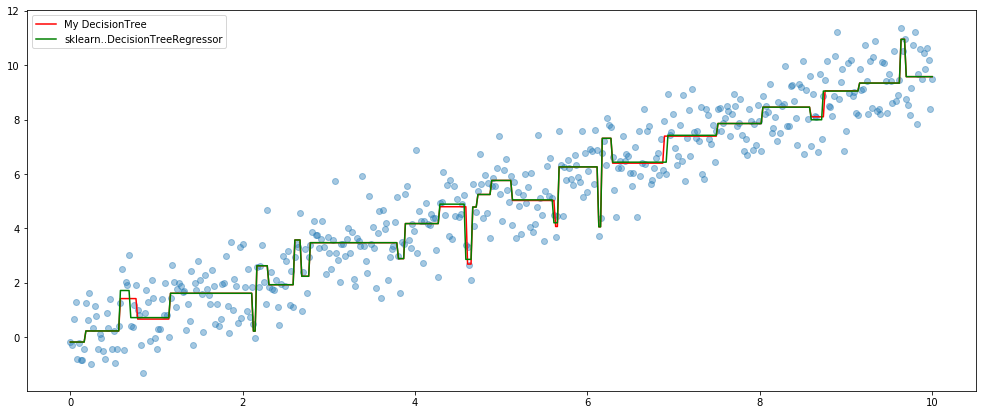

In [412]:
myX = np.linspace(0, 10, 500).reshape(500, 1)
myy = myX[:].reshape(500) + norm.rvs(size=len(myX), scale=1)
max_depth = 5

d = DecisionTree(max_depth=max_depth)
d.fit(myX, myy)
# d.root.print_()
predicted = d.predict(myX)

good_model = DecisionTreeRegressor(max_depth=max_depth)
good_model.fit(myX, myy)
good_predicted = good_model.predict(myX)

plot.figure(figsize=(17, 7))
plot.scatter(myX.reshape(500), myy, alpha=0.4)
plot.plot(myX.reshape(500), predicted, color='red', label='My DecisionTree')
plot.plot(myX.reshape(500), good_predicted, color='green', label='sklearn..DecisionTreeRegressor')
plot.legend()
plot.show()